In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
from google.colab import files
uploaded = files.upload()

Saving E-commerce_data.xlsx to E-commerce_data (1).xlsx


In [7]:
df = pd.read_excel('/content/E-commerce_data (1).xlsx')

In [10]:
xls = pd.ExcelFile('/content/E-commerce_data (1).xlsx')
customers = xls.parse('customers')
genders = xls.parse('genders')
cities = xls.parse('cities')
transactions = xls.parse('transactions')
branches = xls.parse('branches')
merchants = xls.parse('merchants')

In [11]:
data = customers.merge(genders, on='gender_id', how='left') \
                .merge(cities, on='city_id', how='left') \
                .merge(transactions, on='customer_id', how='left') \
                .merge(branches, on='branch_id', how='left') \
                .merge(merchants, on='merchant_id', how='left')

#Preprocessing & cleaning


In [12]:
# Number of transactions per customer
transaction_count = transactions.groupby('customer_id').size().reset_index(name='transaction_count')

In [13]:
# Success rate of transactions (assuming 'Success' in transaction_status means completed)
transactions['is_success'] = (transactions['transaction_status'] == 'Success').astype(int)
success_rate = transactions.groupby('customer_id')['is_success'].mean().reset_index(name='success_rate')

In [14]:
data = data.merge(transaction_count, on='customer_id', how='left') \
           .merge(success_rate, on='customer_id', how='left')

In [15]:
# Handle missing values
data = data.fillna({'transaction_count': 0, 'success_rate': 0})

In [16]:
# Feature selection: Demographics (gender, city) and Transactional (count, success rate)
features = ['gender_name', 'city_name', 'transaction_count', 'success_rate']
data_selected = data[features].drop_duplicates(subset=['gender_name', 'city_name'])

#preparing

In [ ]:
# Encode categorical variables
data_selected = pd.get_dummies(data_selected, columns=['gender_name', 'city_name'], drop_first=True)


In [22]:
# Handle outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

data_selected = remove_outliers(data_selected, 'transaction_count')
data_selected = remove_outliers(data_selected, 'success_rate')


In [23]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_selected)

#Model : K-Means Clustering

In [24]:
# Explore different numbers of clusters
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

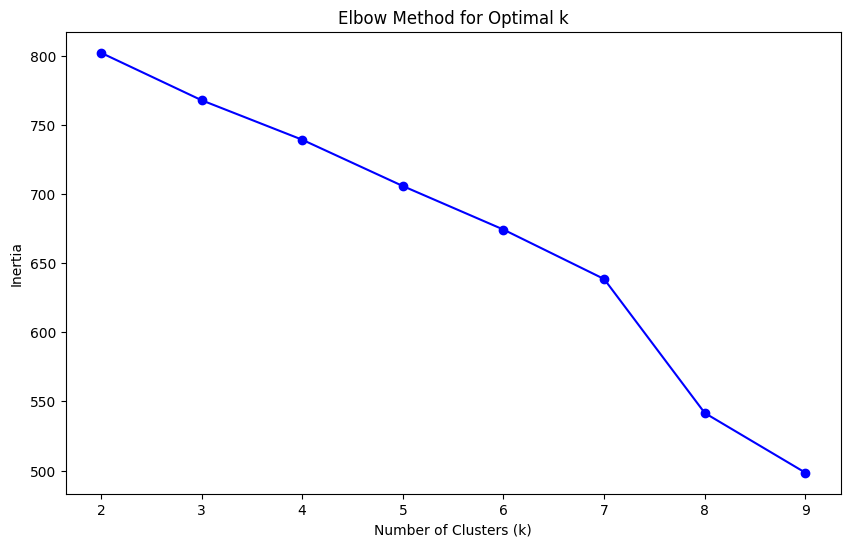

In [25]:
# Plot Elbow Curve (Inertia)
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()



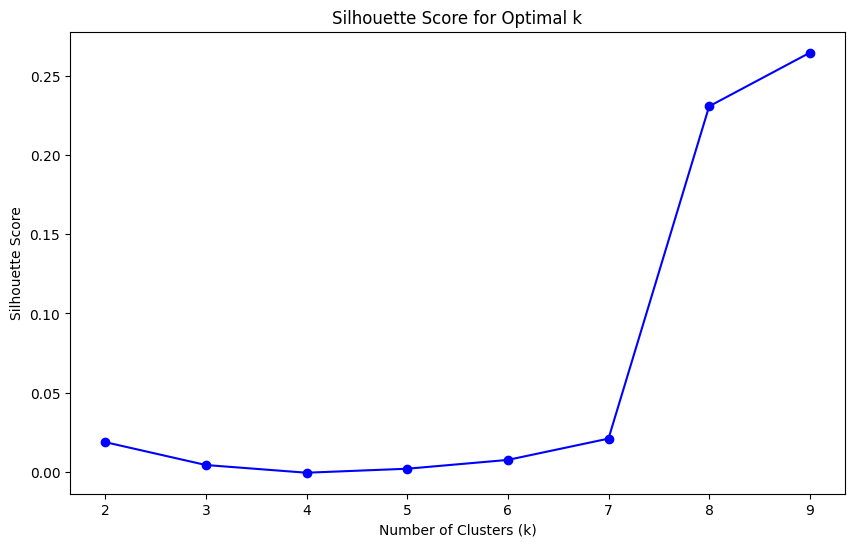

In [26]:
# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [27]:
# Choose optimal k (assume k=4, adjust after running)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [28]:
# Add cluster labels to the data
data_selected['Cluster'] = clusters


In [29]:
# 5. Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

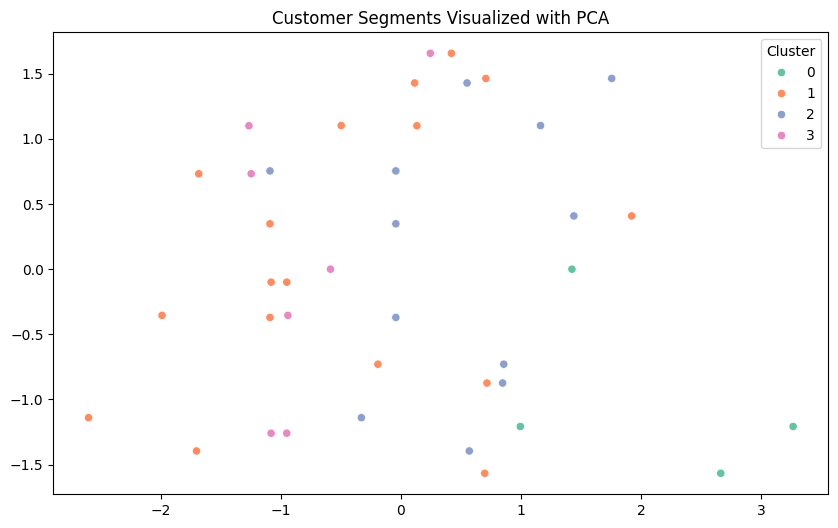

In [30]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_selected['Cluster'], palette='Set2')
plt.title('Customer Segments Visualized with PCA')
plt.show()

#Segment Analysis

In [31]:
cluster_summary = data_selected.groupby('Cluster').mean()
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
         transaction_count  success_rate  gender_name_Male  city_name_Aswan  \
Cluster                                                                       
0                 8.250000           0.0          0.500000         0.000000   
1                 3.941176           0.0          0.058824         0.000000   
2                 5.500000           0.0          0.916667         0.166667   
3                 3.000000           0.0          0.857143         0.000000   

         city_name_Asyut  city_name_Beni Suef  city_name_Cairo  \
Cluster                                                          
0               0.000000             0.000000         0.000000   
1               0.058824             0.058824         0.058824   
2               0.083333             0.083333         0.083333   
3               0.000000             0.000000         0.000000   

         city_name_Damanhur  city_name_Damietta  \
Cluster                                           
0       

#evaluation

In [32]:
print(f"\nFinal Silhouette Score for k={optimal_k}: {silhouette_score(X_scaled, clusters):.4f}")
print(f"Final Inertia for k={optimal_k}: {kmeans.inertia_:.4f}")


Final Silhouette Score for k=4: -0.0004
Final Inertia for k=4: 739.1872


#Insights and Recommendations (6 Insights)

In [33]:
print("\n6 Insights and Coupon Strategies:")
print("1. Cluster 0: High transaction count, low success rate - Frequent but unsuccessful shoppers. Offer troubleshooting coupons.")
print("2. Cluster 1: Low transaction count, high success rate - Loyal but infrequent. Provide incentives for more purchases.")
print("3. Cluster 2: Moderate count and success - Average customers. Use time-limited coupons to boost activity.")
print("4. Cluster 3: High count and success - Top customers. Offer VIP coupons for retention.")
print("5. Gender trends: Check dummies (e.g., gender_name_Male) for gender-specific offers.")
print("6. City trends: Clusters tied to cities (e.g., city_name_Cairo) may need localized discounts.")



6 Insights and Coupon Strategies:
1. Cluster 0: High transaction count, low success rate - Frequent but unsuccessful shoppers. Offer troubleshooting coupons.
2. Cluster 1: Low transaction count, high success rate - Loyal but infrequent. Provide incentives for more purchases.
3. Cluster 2: Moderate count and success - Average customers. Use time-limited coupons to boost activity.
4. Cluster 3: High count and success - Top customers. Offer VIP coupons for retention.
5. Gender trends: Check dummies (e.g., gender_name_Male) for gender-specific offers.
6. City trends: Clusters tied to cities (e.g., city_name_Cairo) may need localized discounts.
